# A tour of PyCIEMSS interfaces and functionality

### Load dependencies and interfaces

In [1]:
import os
import pyciemss
import torch
import pandas as pd
import numpy as np
from typing import Dict, List, Callable

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
    start_time_param_value_objective,
)

smoke_test = "CI" in os.environ

### Select models and data

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type2_petrinet.json")
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
dataset2 = os.path.join(DATA_PATH, "traditional.csv")

### Set parameters for sampling

In [3]:
start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_samples = 3 if smoke_test else 100

## Sample interface
Take `num_samples` number of samples from the (prior) distribution invoked by the chosen model.

### Sample from model 1

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.211798,0.590985,0.447774,0.151936,0.088656,5.745734,0.551484,47.297039,5.842462,23.841494,73.001450,19339914.0,23.841494,47.297039,5.842462,0.551484
1,1,0,20.0,0.211798,0.590985,0.447774,0.151936,0.088656,5.745734,1.986621,76.429649,10.477629,38.540241,203.982300,19339712.0,38.540241,76.429649,10.477629,1.986621
2,2,0,30.0,0.211798,0.590985,0.447774,0.151936,0.088656,5.745734,4.385444,123.519821,17.073627,62.286137,416.487762,19339422.0,62.286137,123.519821,17.073627,4.385444
3,3,0,40.0,0.211798,0.590985,0.447774,0.151936,0.088656,5.745734,8.272989,199.615936,27.611687,100.659248,760.029602,19338948.0,100.659248,199.615936,27.611687,8.272989
4,4,0,50.0,0.211798,0.590985,0.447774,0.151936,0.088656,5.745734,14.556961,322.572571,44.623783,162.664276,1315.221436,19338190.0,162.664276,322.572571,44.623783,14.556961


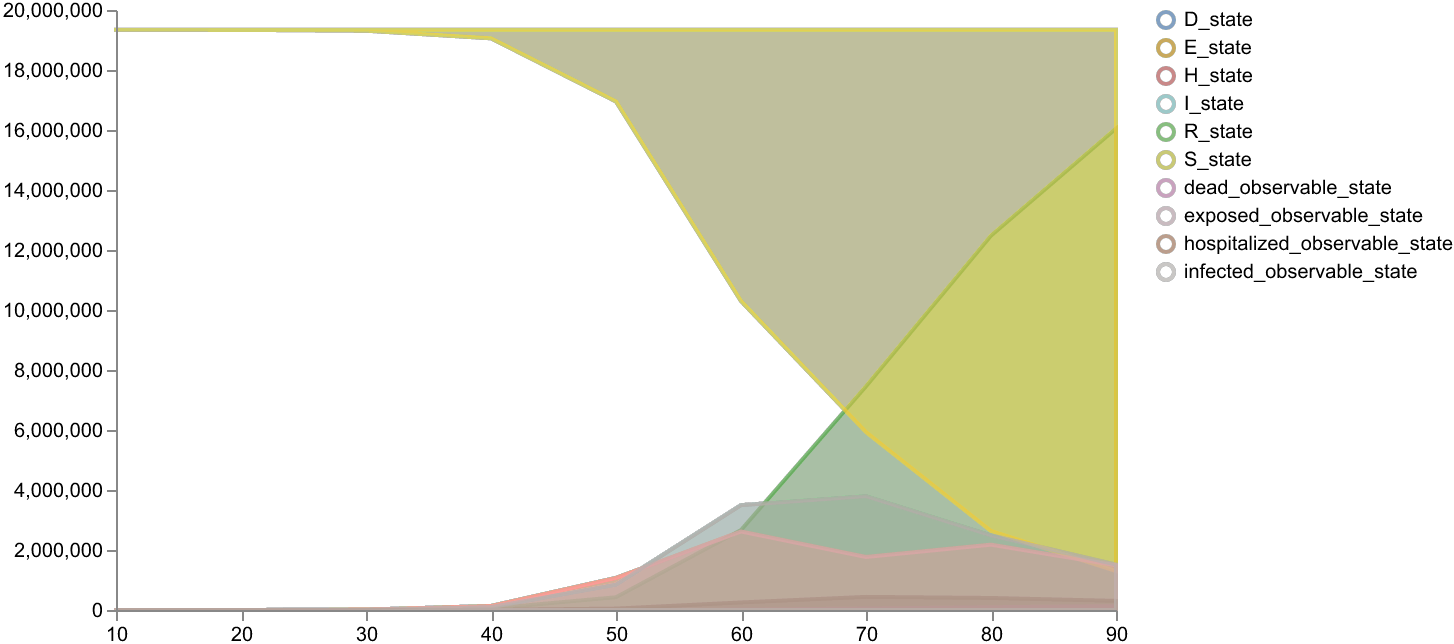

In [4]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Sample from model 2

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_beta_nc_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.503478,0.111912,0.590678,0.310165,0.035541,0.029803,9.749119,0.047312,83.281723,1.698614,50.086777,90.713242,19339814.0,50.086777,83.281723,1.698614,0.047312
1,1,0,20.0,0.503478,0.111912,0.590678,0.310165,0.035541,0.029803,9.749119,0.235602,238.824112,5.172093,143.686600,362.542145,19339272.0,143.686600,238.824112,5.172093,0.235602
2,2,0,30.0,0.503478,0.111912,0.590678,0.310165,0.035541,0.029803,9.749119,0.783386,684.914551,14.874487,412.085999,1142.431274,19337784.0,412.085999,684.914551,14.874487,0.783386
3,3,0,40.0,0.503478,0.111912,0.590678,0.310165,0.035541,0.029803,9.749119,2.355366,1963.666626,42.658798,1181.567993,3378.891602,19333466.0,1181.567993,1963.666626,42.658798,2.355366
4,4,0,50.0,0.503478,0.111912,0.590678,0.310165,0.035541,0.029803,9.749119,6.862128,5625.167480,122.266327,3385.630859,9789.372070,19321136.0,3385.630859,5625.167480,122.266327,6.862128


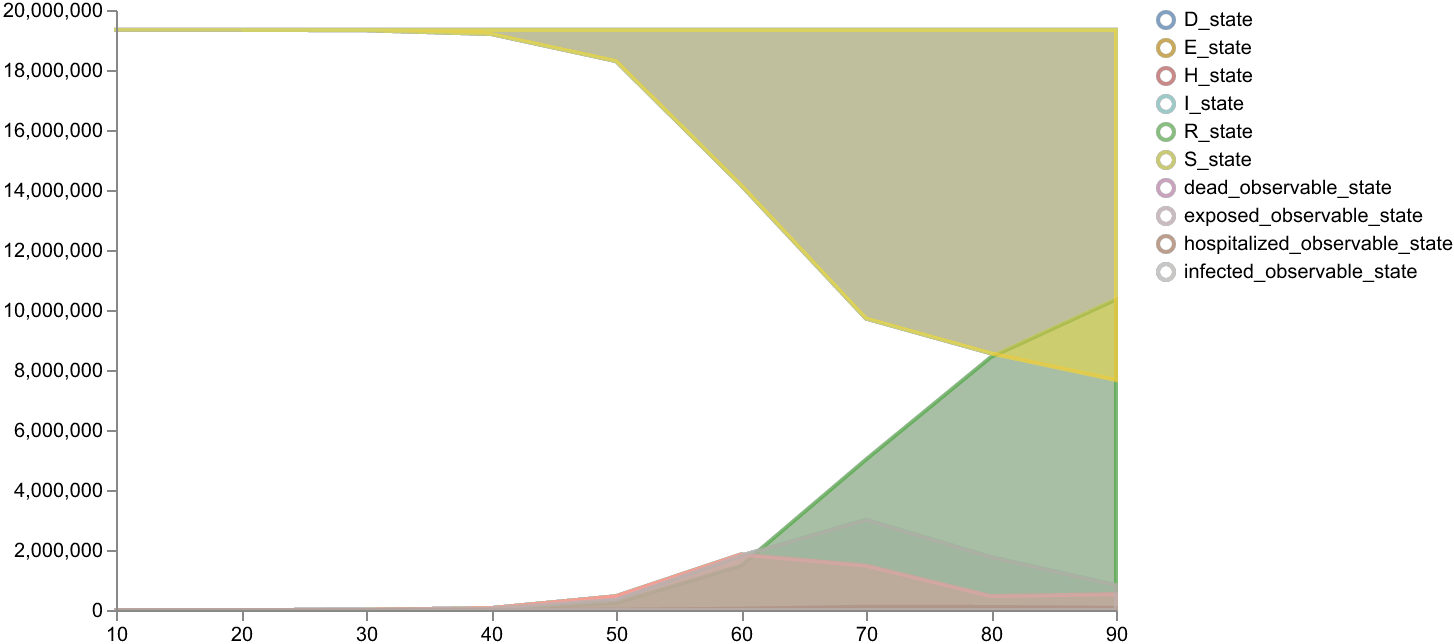

In [5]:
result2 = pyciemss.sample(model2, end_time, logging_step_size, num_samples, start_time=start_time)
display(result2['data'].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result2["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Calibrate interface
Calibrate a model to a dataset by mapping model state varibales or observables to columns in the dataset. The `data_mapping` must be a dictionary where the keys are column names in the dataset, and the values are the state variables or observables they are mapped to (as in, `data_mapping = {"column_name": "observable/state_variable"}`).

In [7]:
data_mapping = {"case": "infected", "hosp": "hospitalized"} # data is mapped to observables
# data_mapping = {"case": "I", "hosp": "H"} # data is mapped to state variables

num_iterations = 10 if smoke_test else 1000
calibrated_results = pyciemss.calibrate(model1, dataset1, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
calibrated_results

Data printout: This dataset contains 2 rows of data. The first column, Timestamp, begins at 1.1 and ends at 3.3. The subsequent columns are named: case, hosp


{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 8.15075358748436}

In [8]:
parameter_estimates()

{'persistent_beta_c': tensor(0.7682, grad_fn=<ExpandBackward0>),
 'persistent_kappa': tensor(0.7438, grad_fn=<ExpandBackward0>),
 'persistent_gamma': tensor(0.3989, grad_fn=<ExpandBackward0>),
 'persistent_hosp': tensor(0.1496, grad_fn=<ExpandBackward0>),
 'persistent_death_hosp': tensor(0.0224, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(8.9359, grad_fn=<ExpandBackward0>)}

### Use calibrated parameter estimates in `sample` to sample from the calibrated model (posterior distr.)

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.393743,0.686994,0.389799,0.152687,0.077324,8.724837,0.579406,83.110924,7.880644,42.381161,92.228737,19339832.0,42.381161,83.110924,7.880644,0.579406
1,1,0,20.0,0.393743,0.686994,0.389799,0.152687,0.077324,8.724837,2.781347,226.751205,22.844921,115.648766,359.573242,19339306.0,115.648766,226.751205,22.844921,2.781347
2,2,0,30.0,0.393743,0.686994,0.389799,0.152687,0.077324,8.724837,8.879053,618.627441,62.511410,315.523590,1090.074463,19337944.0,315.523590,618.627441,62.511410,8.879053
3,3,0,40.0,0.393743,0.686994,0.389799,0.152687,0.077324,8.724837,25.526678,1687.299194,170.551025,860.649048,3083.030273,19334212.0,860.649048,1687.299194,170.551025,25.526678
4,4,0,50.0,0.393743,0.686994,0.389799,0.152687,0.077324,8.724837,70.931404,4598.731934,465.041992,2346.156982,8517.644531,19324010.0,2346.156982,4598.731934,465.041992,70.931404


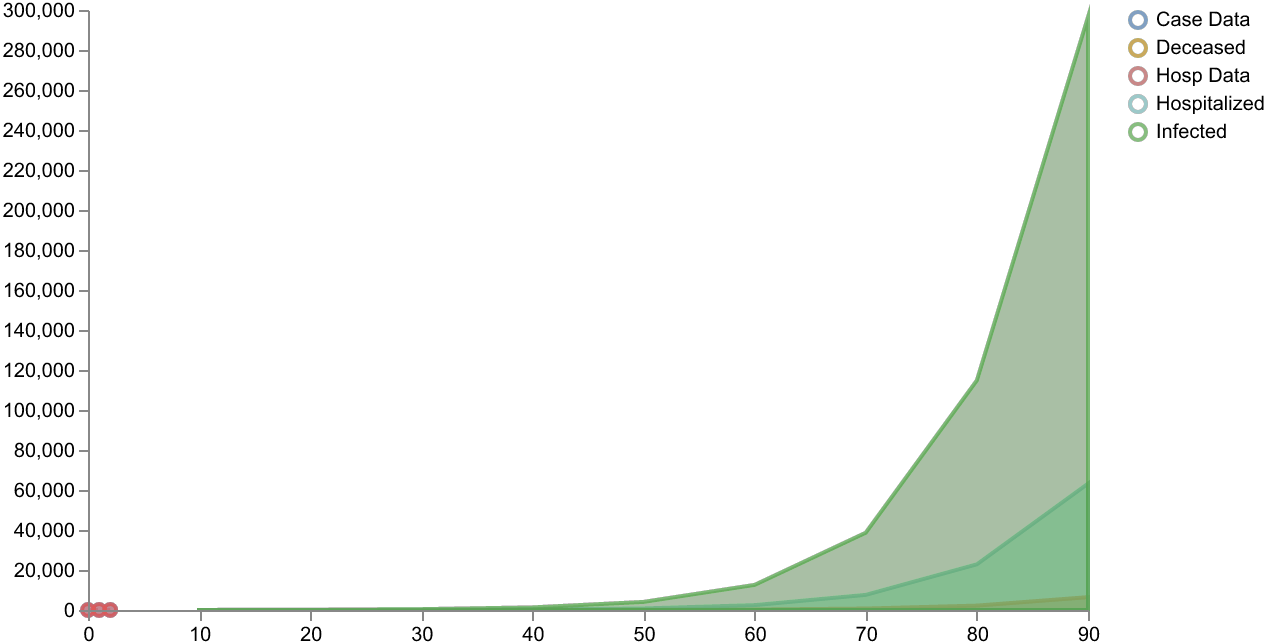

In [9]:
calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "dead_observable_state": "Deceased", 
        "hospitalized_observable_state": "Hospitalized",
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data",
        "hosp": "Hosp Data"
        }
data_df = pd.read_csv(dataset1)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state", "hospitalized_observable_state", "dead_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Ensemble Sample Interface
Sample from an ensemble of model 1 and model 2 

,timepoint_id,sample_id,timepoint_days,model_0/weight_param,model_1/weight_param,model_0/persistent_beta_c_param,model_0/persistent_kappa_param,model_0/persistent_gamma_param,model_0/persistent_hosp_param,model_0/persistent_death_hosp_param,...,S_state,I_state,E_state,R_state,H_state,D_state,infected_state,exposed_state,hospitalized_state,dead_state
0,0,0,0.0,0.390044,0.609956,0.73731,0.512812,0.269858,0.183346,0.064368,...,19339986.0,13.929174,40.000000,0.000000,0.000000,0.000000,13.929174,40.000000,0.000000,0.000000
1,1,0,1.0,0.390044,0.609956,0.73731,0.512812,0.269858,0.183346,0.064368,...,19339980.0,19.842855,37.370132,3.157749,0.533950,0.002451,19.842855,37.370132,0.533950,0.002451
2,2,0,2.0,0.390044,0.609956,0.73731,0.512812,0.269858,0.183346,0.064368,...,19339970.0,24.323442,37.152145,7.351904,1.127770,0.010263,24.323442,37.152145,1.127770,0.010263
3,3,0,3.0,0.390044,0.609956,0.73731,0.512812,0.269858,0.183346,0.064368,...,19339958.0,28.074162,38.444202,12.400656,1.739272,0.023759,28.074162,38.444202,1.739272,0.023759
4,4,0,4.0,0.390044,0.609956,0.73731,0.512812,0.269858,0.183346,0.064368,...,19339948.0,31.508190,40.740093,18.216457,2.350876,0.043009,31.508190,40.740093,2.350876,0.043009


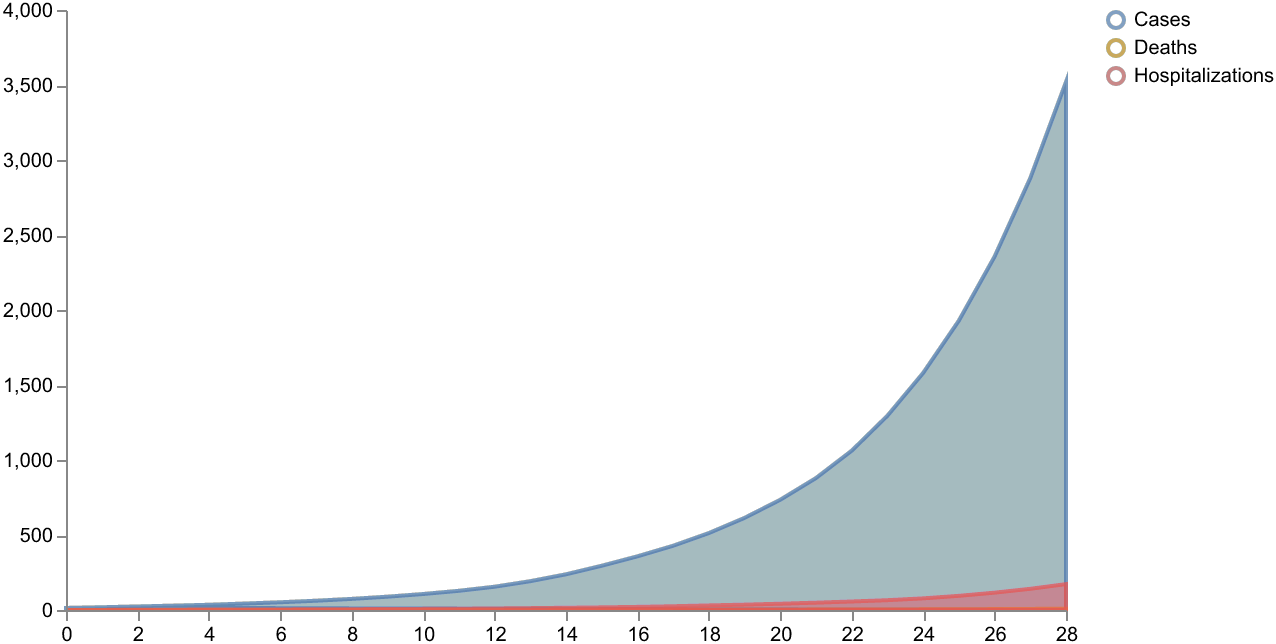

In [9]:
train_end_point = None   # Use train_end_point = None if there is no calibration
if train_end_point is None:
    end_time_ensemble = 28.0
else:
    end_time_ensemble = train_end_point + 28.0
logging_step_size_ensemble = 1.0
model_paths = [model1, model2]
solution_mappings = [
    lambda x: x,
    lambda x: x,
]  # Conveniently, these two models operate on exactly the same state space, with the same names.

ensemble_result = pyciemss.ensemble_sample(
    model_paths,
    solution_mappings,
    end_time_ensemble,
    logging_step_size_ensemble,
    num_samples,
    start_time=start_time,
    time_unit="days",
)

display(ensemble_result["data"].head())

# Plot the ensemble result for cases, hospitalizations, and deaths
nice_labels = {
    "dead_state": "Deaths",
    "hospitalized_state": "Hospitalizations",
    "infected_state": "Cases",
}
schema = plots.trajectories(
    ensemble_result["data"],
    keep=["infected_state", "hospitalized_state", "dead_state"],
    relabel=nice_labels,
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

#### CDC reformatting of ensemble output

In [10]:
display(ensemble_result["ensemble_quantiles"])
from pyciemss.integration_utils.result_processing import cdc_format

q_ensemble_data = cdc_format(
    ensemble_result["ensemble_quantiles"],
    time_unit="days",
    solution_string_mapping={
        "infected_state": "daily cases",
        "hospitalized_state": "daily hosp",
        "dead_state": "cum death",
    },
    forecast_start_date="2023-08-03",
    location="US",
    drop_column_names=[
        "timepoint_id",
        "number_days",
        "output",
    ],
    train_end_point=train_end_point,
)
print("CDC Format:")
display(q_ensemble_data)

,timepoint_id,number_days,output,type,quantile,value
0,0,0.0,model_0/S_state,quantile,0.010,1.933999e+07
1,0,0.0,model_0/S_state,quantile,0.025,1.933999e+07
2,0,0.0,model_0/S_state,quantile,0.050,1.933999e+07
3,0,0.0,model_0/S_state,quantile,0.100,1.933999e+07
4,0,0.0,model_0/S_state,quantile,0.150,1.933999e+07
...,...,...,...,...,...,...
20005,28,28.0,dead_state,quantile,0.850,4.409579e+00
20006,28,28.0,dead_state,quantile,0.900,5.648811e+00
20007,28,28.0,dead_state,quantile,0.950,8.788593e+00
20008,28,28.0,dead_state,quantile,0.975,1.201829e+01


CDC Format:


,type,quantile,value,target,forecast_date,target_end_date,location
17342,quantile,0.010,1.715008,0.0 days ahead daily cases,2023-08-03,2023-08-03,US
17343,quantile,0.025,2.351556,0.0 days ahead daily cases,2023-08-03,2023-08-03,US
17344,quantile,0.050,2.972652,0.0 days ahead daily cases,2023-08-03,2023-08-03,US
17345,quantile,0.100,3.431798,0.0 days ahead daily cases,2023-08-03,2023-08-03,US
17346,quantile,0.150,3.909159,0.0 days ahead daily cases,2023-08-03,2023-08-03,US
...,...,...,...,...,...,...,...
20005,quantile,0.850,4.409579,28.0 days ahead cum death,2023-08-03,2023-08-31,US
20006,quantile,0.900,5.648811,28.0 days ahead cum death,2023-08-03,2023-08-31,US
20007,quantile,0.950,8.788593,28.0 days ahead cum death,2023-08-03,2023-08-31,US
20008,quantile,0.975,12.018292,28.0 days ahead cum death,2023-08-03,2023-08-31,US


## Calibrate ensemble Interface
Calibrate an ensemble of model 1 and model 2 to data

In [5]:
num_iterations = 10 if smoke_test else 100
model_paths = [model1, model2]
solution_mappings = [lambda x : x, lambda x : x]
data_mapping = {'case': 'infected', 'hosp': 'hospitalized'}
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset1, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
print(parameter_estimates())

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 2 rows of data. The first column, Timestamp, begins at 1.1 and ends at 3.3. The subsequent columns are named: case, hosp
{'model_weights': tensor([0.6831, 0.3169], grad_fn=<ExpandBackward0>), 'model_0/persistent_beta_c': tensor(0.1915, grad_fn=<ExpandBackward0>), 'model_0/persistent_kappa': tensor(0.5814, grad_fn=<ExpandBackward0>), 'model_0/persistent_gamma': tensor(0.3833, grad_fn=<ExpandBackward0>), 'model_0/persistent_hosp': tensor(0.1434, grad_fn=<ExpandBackward0>), 'model_0/persistent_death_hosp': tensor(0.0432, grad_fn=<ExpandBackward0>), 'model_0/persistent_I0': tensor(7.3812, grad_fn=<ExpandBackward0>), 'model_1/persistent_beta_c': tensor(0.4611, grad_fn=<ExpandBackward0>), 'model_1/persistent_beta_nc': tensor(0.2439, grad_fn=<ExpandBackward0>), 'model_1/persistent_kappa': tensor(0.6415, grad_fn=<ExpandBackward0>), 'model_1/persistent_gamma': tensor(0.3451, grad_fn=<ExpandBackward0>), 'model_1/persistent_hosp': tensor(0.1205, grad_fn=<Expan

### Use calibrated parameter estimates in `ensemble_sample` to sample from the calibrated ensemble model

,timepoint_id,sample_id,timepoint_unknown,model_0/weight_param,model_1/weight_param,model_0/persistent_beta_c_param,model_0/persistent_kappa_param,model_0/persistent_gamma_param,model_0/persistent_hosp_param,model_0/persistent_death_hosp_param,...,D_state,E_state,H_state,I_state,R_state,S_state,infected_state,exposed_state,hospitalized_state,dead_state
0,0,0,10.0,0.632953,0.367047,0.553498,0.378088,0.341927,0.16572,0.078025,...,0.385055,24.851246,4.266328,18.297140,54.011383,19339936.0,18.297140,24.851246,4.266328,0.385055
1,1,0,20.0,0.632953,0.367047,0.553498,0.378088,0.341927,0.16572,0.078025,...,1.104795,25.535400,4.972380,18.338739,114.994621,19339872.0,18.338739,25.535400,4.972380,1.104795
2,2,0,30.0,0.632953,0.367047,0.553498,0.378088,0.341927,0.16572,0.078025,...,1.900414,28.126987,5.369238,19.914263,179.003601,19339804.0,19.914263,28.126987,5.369238,1.900414
3,3,0,40.0,0.632953,0.367047,0.553498,0.378088,0.341927,0.16572,0.078025,...,2.779119,31.945019,5.989234,22.477871,249.810806,19339726.0,22.477871,31.945019,5.989234,2.779119
4,4,0,50.0,0.632953,0.367047,0.553498,0.378088,0.341927,0.16572,0.078025,...,3.774672,36.751270,6.831228,25.793690,330.331573,19339672.0,25.793690,36.751270,6.831228,3.774672


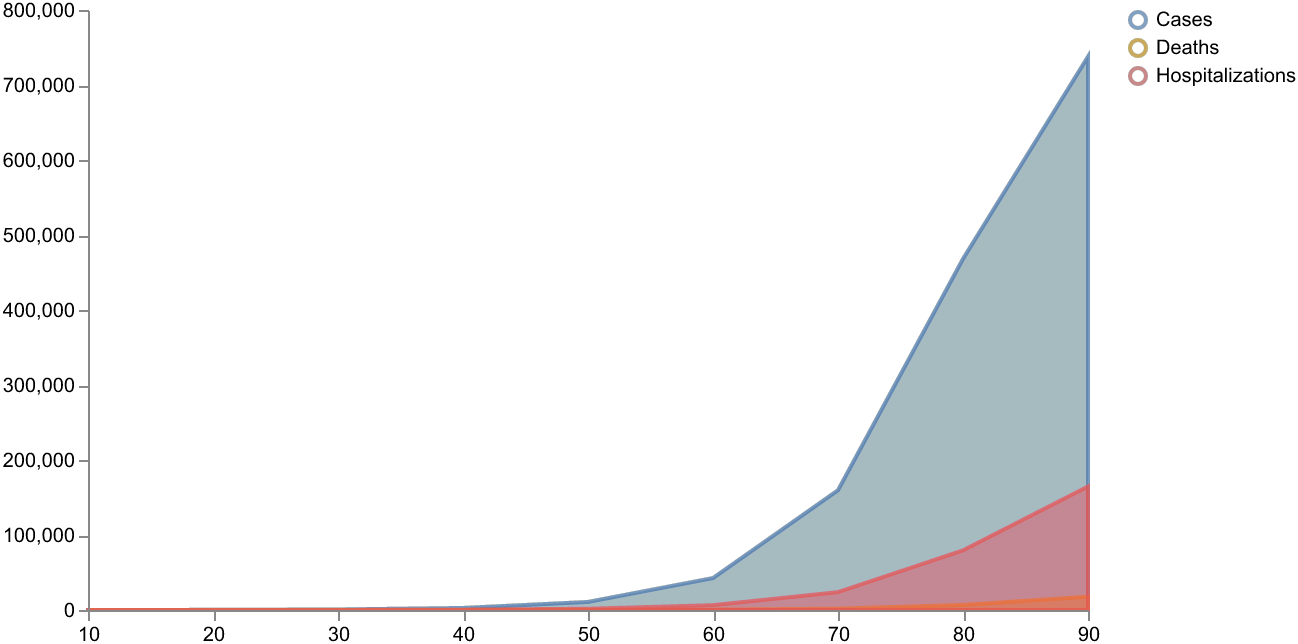

In [7]:
train_end_point = 3.3   # Use train_end_point = None if there is no calibration
if train_end_point is None:
    end_time_ensemble = 28.0
else:
    end_time_ensemble = train_end_point + 28.0
calibrated_ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time_ensemble, logging_step_size_ensemble, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_ensemble_result['data'].head())

# Plot the ensemble result for cases, hospitalizations, and deaths
nice_labels={"dead_state": "Deaths", 
                 "hospitalized_state": "Hospitalizations",
                 "infected_state": "Cases"
                }
schema = plots.trajectories(calibrated_ensemble_result["data"], 
                           keep=["infected_state", "hospitalized_state", "dead_state"], 
                           relabel=nice_labels,
                          )
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static parameter intervention
Change the value of the parameter `p_cbeta` to 0.5 on day 1

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.5,15.108353,1.260775,0.074486,999.665222
1,1,0,2.0,0.5,15.108353,1.943885,0.178919,998.877747
2,2,0,3.0,0.5,15.108353,2.995645,0.339897,997.665833
3,3,0,4.0,0.5,15.108353,4.612971,0.587878,995.799622
4,4,0,5.0,0.5,15.108353,7.095218,0.969521,992.935669


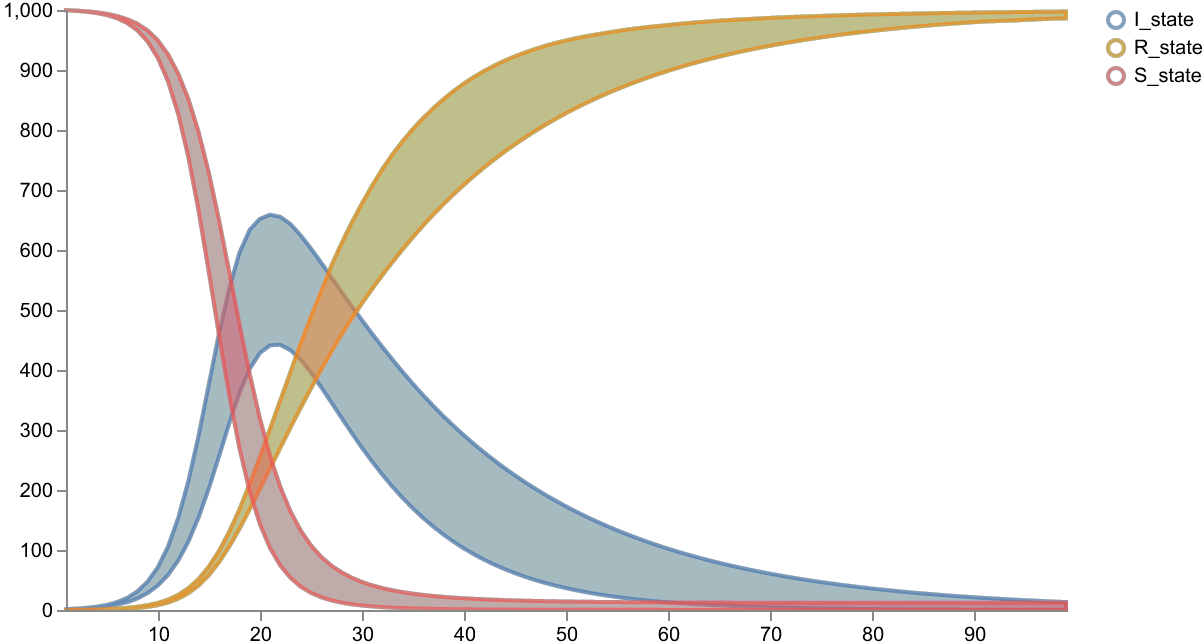

In [10]:
start_time = 0.0
end_time = 100.0
logging_step_size = 1.0
num_samples = 5 if smoke_test else 100

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={torch.tensor(1.): {"p_cbeta": torch.tensor(0.5)}})
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static state intervention
Change the Infected state `I` to 20.0 on day 5

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.445223,8.8699,1.393650,0.133708,999.472595
1,1,0,2.0,0.445223,8.8699,1.941720,0.320025,998.738159
2,2,0,3.0,0.445223,8.8699,2.704279,0.579563,997.716370
3,3,0,4.0,0.445223,8.8699,3.764284,0.940930,996.294800
4,4,0,5.0,0.445223,8.8699,5.235861,1.443754,994.320251


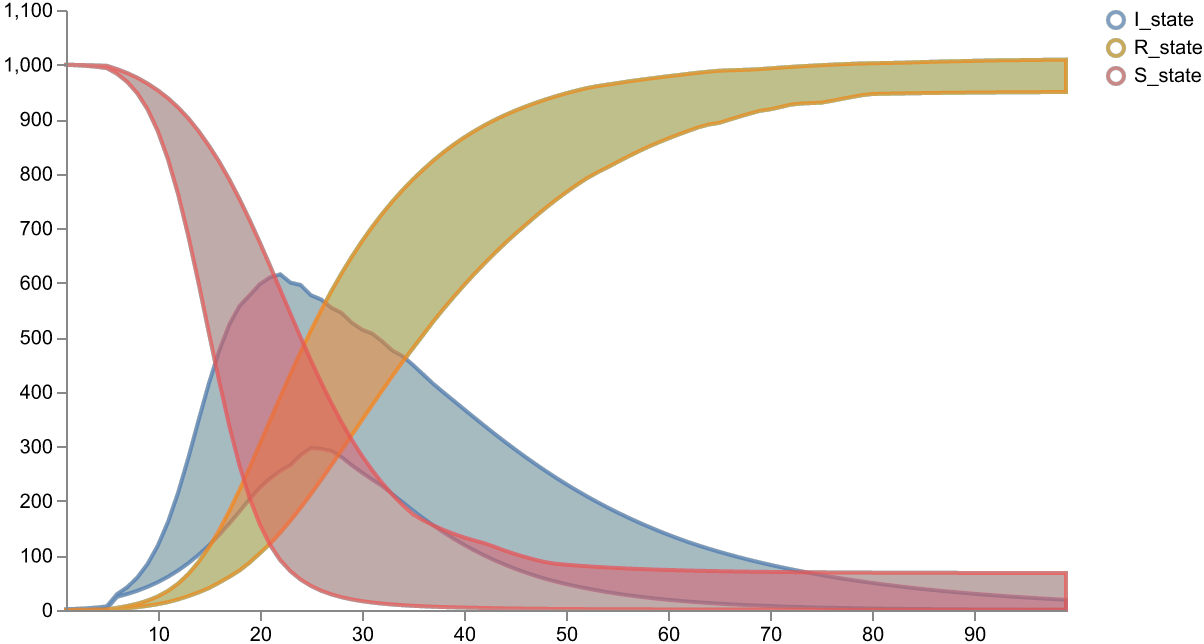

In [11]:
result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_state_interventions={torch.tensor(5.): {"I": torch.tensor(20.0)}}, solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with dynamic parameter interventions
Change the parameter `p_cbeta` from 0.35 to 0.3 when the infectious population `I` exceeds 200.

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.42912,14.21841,1.430832,0.084581,999.483154
1,1,0,2.0,0.42912,14.21841,2.046738,0.205586,998.747925
2,2,0,3.0,0.42912,14.21841,2.926646,0.378645,997.693848
3,3,0,4.0,0.42912,14.21841,4.182574,0.626035,996.191162
4,4,0,5.0,0.42912,14.21841,5.972835,0.979454,994.047668


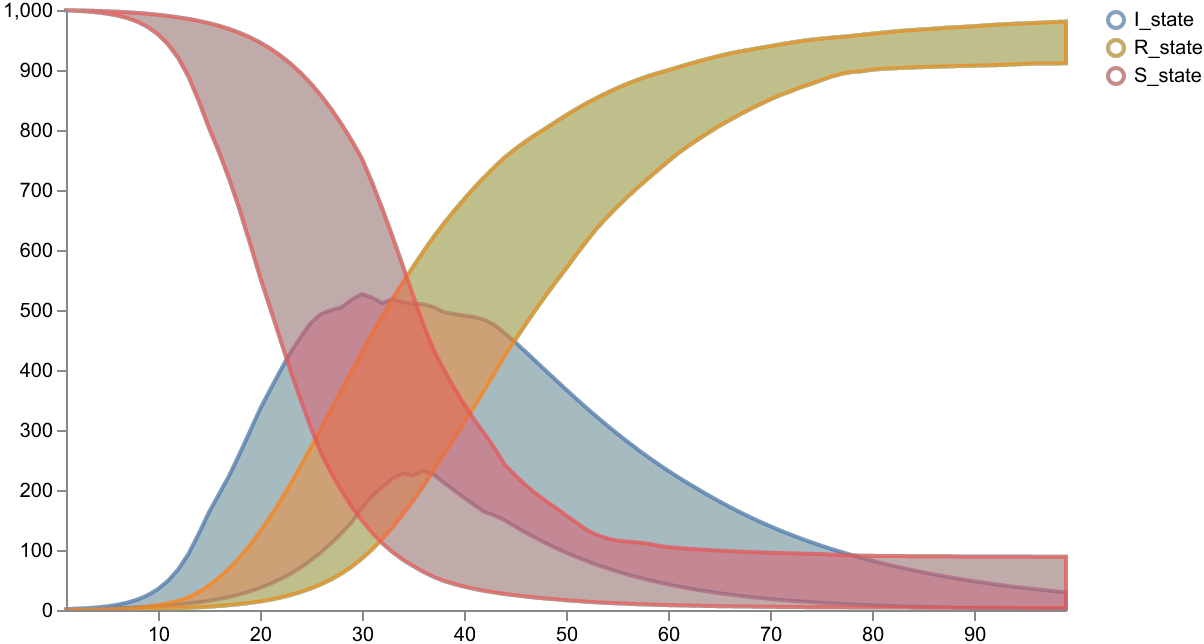

In [12]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    def var_threshold(time, state):
        return state[var] - threshold
    return var_threshold
    
infection_threshold = make_var_threshold("I", torch.tensor(150.0))
dynamic_parameter_interventions1 = {infection_threshold: {"p_cbeta": torch.tensor(0.3)}}

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_parameter_interventions=dynamic_parameter_interventions1, 
                         solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [13]:
# # NOTE: If you change the solver to "euler", you need to specify the step size in `solver_options` as below:
# # Specify solver options including the step_size
# solver_options = {"step_size": 1e-2}  # Example step size, adjust as needed
# result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
#                          dynamic_parameter_interventions=dynamic_parameter_interventions1, 
#                          solver_method="euler",
#                          solver_options=solver_options)

## Sample interface with dynamic state interventions
Reduce the susceptible population `S` to 200.0 when infections `I` exceed 400. 

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.340304,12.40789,1.296031,0.092009,999.611755
1,1,0,2.0,0.340304,12.40789,1.679444,0.211247,999.109253
2,2,0,3.0,0.340304,12.40789,2.175860,0.365744,998.458374
3,3,0,4.0,0.340304,12.40789,2.818296,0.565884,997.616821
4,4,0,5.0,0.340304,12.40789,3.649226,0.825072,996.525513


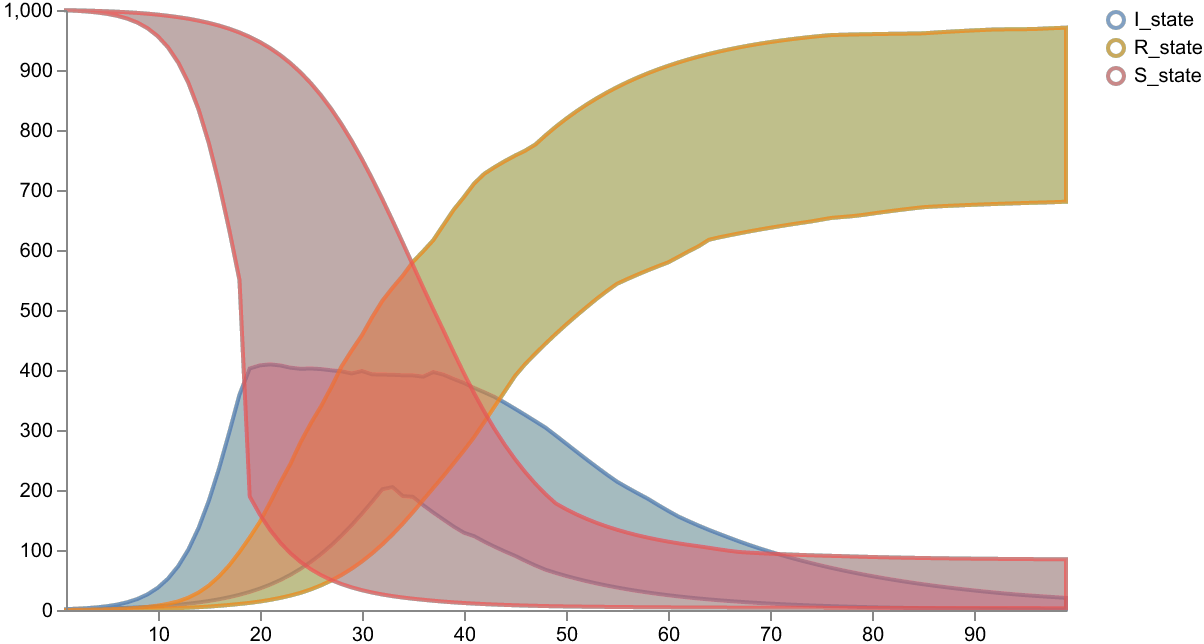

In [14]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    def var_threshold(time, state):
        return state[var] - threshold  
    return var_threshold
    
infection_threshold = make_var_threshold("I", torch.tensor(400.0))
dynamic_state_interventions1 = {infection_threshold: {"S": torch.tensor(200.0)}} 

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_state_interventions=dynamic_state_interventions1, 
                         solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Optimize interface
Get infections below 300 individuals at 40 days for SIR model with minimum change to current value for intervention parameter

In [15]:
def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)

start_time = 0.0
end_time = 40.0
logging_step_size = 1.0
observed_params = ["I_state"]
intervened_params = ["p_cbeta"]

In [27]:
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]
intervention_time = [torch.tensor(5.0)]

risk_bound = 300.0
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor([x])],
    start_time = intervention_time,
)
opt_result = pyciemss.optimize(
    model3,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=0.0,
    n_samples_ouu=int(1e2),
    maxiter=0,
    maxfeval=20,
    solver_method="euler",
    solver_options={"step_size": logging_step_size/2},
)
print(f'Optimal policy:', opt_result["policy"])
print(opt_result)

 45%|████▌     | 9/20 [00:05<00:06,  1.77it/s]

Optimal policy: tensor([0.1389], dtype=torch.float64)
{'policy': tensor([0.1389], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.2111072303557351
                          x: [ 1.389e-01]
                        nit: 1
      minimization_failures: 0
                       nfev: 9
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 0.2111072303557351
                                   x: [ 1.389e-01]
                                nfev: 9
                               maxcv: 0.0}


### Sample using the optimal policy as an intervention

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,S_state,I_state,R_state
0,0,0,0.0,0.378897,18.709511,1000.000000,1.000000,0.000000
1,1,0,1.0,0.378897,18.709511,999.553711,1.383288,0.063037
2,2,0,2.0,0.378897,18.709511,998.936829,1.913106,0.150228
3,3,0,3.0,0.378897,18.709511,998.084229,2.645126,0.270797
4,4,0,4.0,0.378897,18.709511,996.906738,3.655854,0.437469


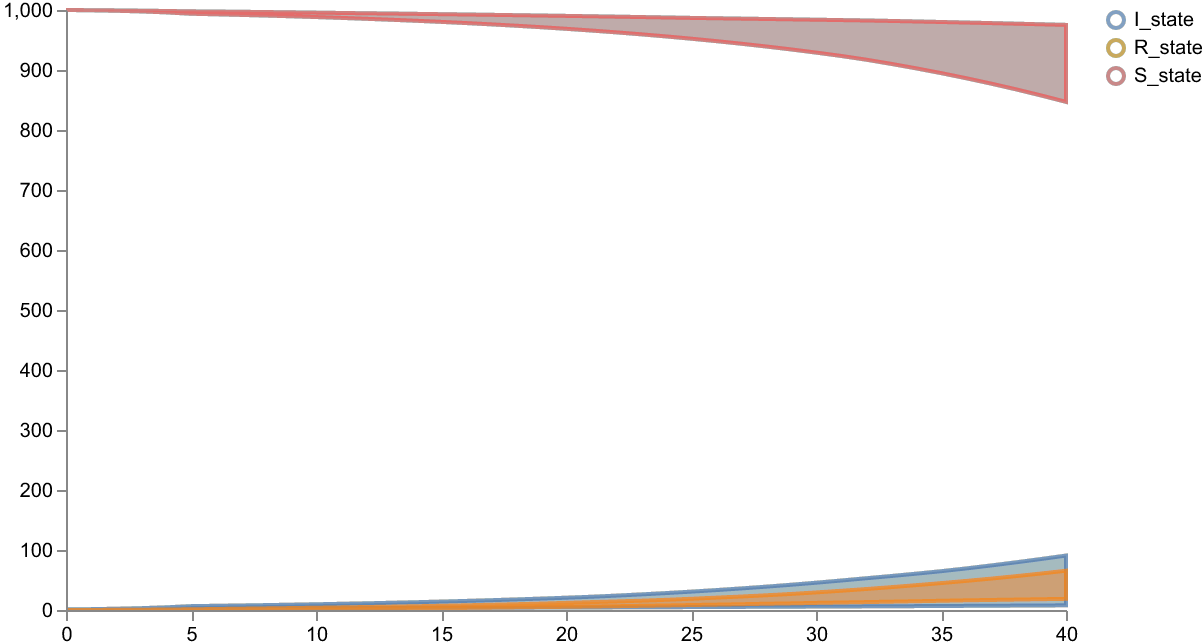

In [28]:
num_samples = 10 if smoke_test else 100
result = pyciemss.sample(
    model3,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result["policy"]),
    solver_method="euler",
    solver_options={"step_size": 1e-2},
)

display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Optimize interface for optimizing start time

In [18]:
initial_guess_interventions = 0.0
bounds_interventions = [[start_time], [end_time]]

risk_bound = 300.0
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
objfun = lambda x: -x

static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = torch.tensor([0.15]),
)
opt_result = pyciemss.optimize(
    model3,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=0.0,
    n_samples_ouu=int(1e2),
    maxiter=1,
    maxfeval=2,
    solver_method="euler",
    solver_options={"step_size": logging_step_size/2},
)

print(f'Optimal policy:', opt_result["policy"])
print(opt_result)

6it [00:28,  4.72s/it]                       

Optimal policy: tensor([9.1716], dtype=torch.float64)
{'policy': tensor([9.1716], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -9.171524094255794
                          x: [ 9.172e+00]
                        nit: 1
      minimization_failures: 2
                       nfev: 4
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: -9.171524094255794
                                   x: [ 9.172e+00]
                                nfev: 2
                               maxcv: 0.0}


### Sample with the intervention implemented at the optimal time

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.349256,9.081274,1.269268,0.124207,999.606506
1,1,0,2.0,0.349256,9.081274,1.610792,0.281846,999.107361
2,2,0,3.0,0.349256,9.081274,2.043811,0.481883,998.474304
3,3,0,4.0,0.349256,9.081274,2.592591,0.735663,997.671936
4,4,0,5.0,0.349256,9.081274,3.287688,1.057535,996.654968


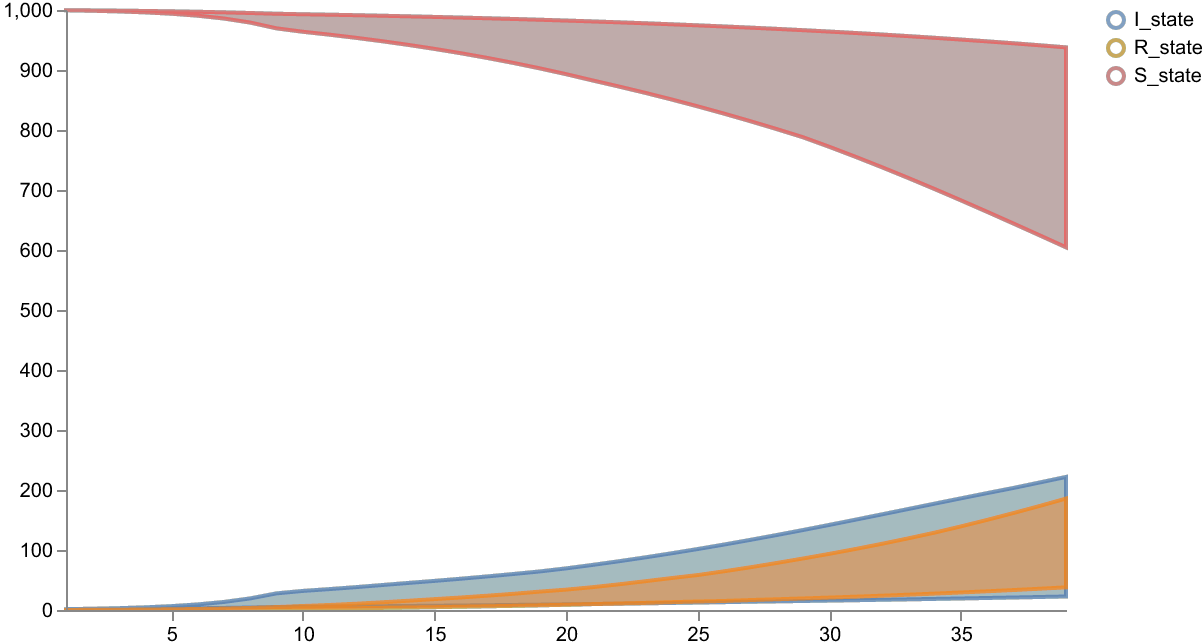

In [19]:
num_samples = 10 if smoke_test else 100
result = pyciemss.sample(
    model3,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result["policy"]),
    solver_method="euler",
    solver_options={"step_size": 1e-2},
)

display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Optimize interface with start time and parameter value optimization for the same parameter

In [36]:
p_cbeta_current = 0.35
initial_guess_interventions = [1.0, 0.15]
bounds_interventions = [[start_time, 0.1], [end_time, 0.5]]

risk_bound = 300.0
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
# Scaling factors for start time and parameter values in the objective function
scaling_factor_obj = [0.25 / (end_time - start_time), 1.0]
objfun = (
    lambda x: -x[0] * scaling_factor_obj[0]
    + np.abs(p_cbeta_current - x[1]) * scaling_factor_obj[1]
)

static_parameter_interventions = start_time_param_value_objective(
    param_name=intervened_params,
)
opt_result = pyciemss.optimize(
    model3,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=0.0,
    n_samples_ouu=int(1e2),
    maxiter=2,
    maxfeval=40,
    # solver_method="euler",
    # solver_options={"step_size": logging_step_size / 2},
    solver_method="rk4",
    solver_options={"step_size": logging_step_size},
)
print(f"Optimal policy:", opt_result["policy"])
print(opt_result)

  2%|▏         | 2/120 [00:02<02:46,  1.41s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
  5%|▌         | 6/120 [00:08<02:57,  1.56s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 36%|███▌      | 43/120 [01:18<01:55,  1.49s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:108: UserWarning: Selected interventions are ou

Optimal policy: tensor([5.7440, 0.1932], dtype=torch.float64)
{'policy': tensor([5.7440, 0.1932], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 0.12091439529260306
                          x: [ 5.744e+00  1.932e-01]
                        nit: 2
      minimization_failures: 3
                       nfev: 119
 lowest_optimization_result: message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
                             success: False
                              status: 4
                                 fun: 0.12091439529260306
                                   x: [ 5.744e+00  1.932e-01]
                                nfev: 40
                               maxcv: 0.001672363281215894}



C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\interfaces.py:964: UserWarning: Optimal intervention policy does not satisfy constraints.Check if the risk_bounds value is appropriate for given problem.Otherwise, try (i) different initial_guess_interventions, (ii) increasing maxiter/maxfeval,and/or (iii) increase n_samples_ouu to improve accuracy of Monte Carlo risk estimation. 
  warnings.warn(


### Sample using the optimal policy as an intervention

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,S_state,I_state,R_state
0,0,0,0.0,0.427836,9.961353,1000.000000,1.000000,0.000000
1,1,0,1.0,0.427836,9.961353,999.494629,1.386655,0.118734
2,2,0,2.0,0.427836,9.961353,998.794312,1.922321,0.283356
3,3,0,3.0,0.427836,9.961353,997.824463,2.663974,0.511531
4,4,0,4.0,0.427836,9.961353,996.482361,3.689956,0.827661


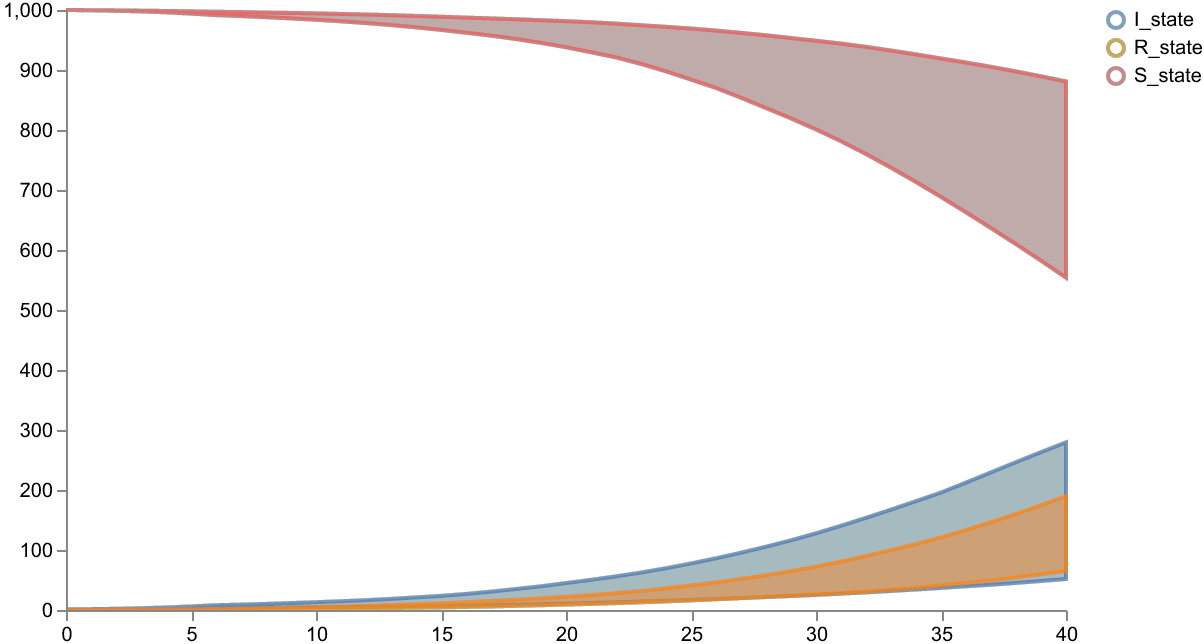

In [39]:
num_samples = 10 if smoke_test else 100
result = pyciemss.sample(
    model3,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result["policy"]),
    # solver_method="euler",
    # solver_options={"step_size": 1e-2},
    solver_method="rk4",
    solver_options={"step_size": logging_step_size},
)

display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)